### Detect difficulty of English text and visualize it

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math
import sys

sys.path.append("../")

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention
from models.attention2 import SimpleAttention2
from models.bert import BERTClassification
from models.simple import SimpleClassification
from dataset.news_category import NewsCategory
from util.metrics import ClassificationMetrics

LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 20
LOAD_FROM = None
DATA_ROOT = Path("../training_data")
NUM_CLASS = 42
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/cyrus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cyrus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dataset and Model

In [2]:
dataset = NewsCategory(DATA_ROOT / "News_Category_Dataset_v3.json")
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])

In [3]:
# train_dataset = Subset(train_dataset, np.arange(10000))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataset = Subset(val_dataset, np.arange(200))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SimpleAttention(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [4]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    train_loss = 0
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    print(f"Total train loss: {train_loss/len(train_dataset):.4f}")

    model.eval()
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/20]
[Batch    0/2292] Loss: 3.7394
[Batch   50/2292] Loss: 3.4143
[Batch  100/2292] Loss: 3.1144
[Batch  150/2292] Loss: 3.1157
[Batch  200/2292] Loss: 3.1279
[Batch  250/2292] Loss: 3.0241
[Batch  300/2292] Loss: 2.9481
[Batch  350/2292] Loss: 2.8485
[Batch  400/2292] Loss: 2.6664
[Batch  450/2292] Loss: 2.8575
[Batch  500/2292] Loss: 2.8649
[Batch  550/2292] Loss: 2.8351
[Batch  600/2292] Loss: 2.5473
[Batch  650/2292] Loss: 2.9540
[Batch  700/2292] Loss: 2.5061
[Batch  750/2292] Loss: 2.6738
[Batch  800/2292] Loss: 2.0754
[Batch  850/2292] Loss: 2.5011
[Batch  900/2292] Loss: 2.4265
[Batch  950/2292] Loss: 2.2665
[Batch 1000/2292] Loss: 2.4872
[Batch 1050/2292] Loss: 2.2755
[Batch 1100/2292] Loss: 2.3076
[Batch 1150/2292] Loss: 2.5546
[Batch 1200/2292] Loss: 2.0487
[Batch 1250/2292] Loss: 2.2728
[Batch 1300/2292] Loss: 2.4150
[Batch 1350/2292] Loss: 1.9907
[Batch 1400/2292] Loss: 2.3129
[Batch 1450/2292] Loss: 2.4509
[Batch 1500/2292] Loss: 2.2330
[Batch 1550/2292] Loss: 2.

KeyboardInterrupt: 

### Visualize weights

In [9]:
batch_idx, (sentences, labels) = next(enumerate(val_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
outputs = model(**inputs)
predictions = torch.argmax(outputs, axis=1)

cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())
print(predictions)

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([64, 74, 74])
tensor(64., device='cuda:0', grad_fn=<SumBackward0>)
tensor([ 8,  0,  2, 12,  4, 23,  2,  8, 16, 14,  8, 19, 27, 14, 28, 28, 35, 14,
        14,  8, 38, 30,  3, 14,  8, 29,  7, 16, 14, 16, 14,  8, 15,  6, 16,  2,
         1,  9,  7, 16,  8, 16,  8, 14, 14,  8,  1, 12,  7, 15,  7,  8, 27, 14,
        14,  8,  8,  8, 38, 21,  8, 18, 22, 35], device='cuda:0')
          [CLS]          trump            ann           ##ih          ##ila          ##ted         online           over          claim            wed           have           very            few          cases        without        testing            ask            any             on          ##col        ##ogist            and           they           ##ll           tell            you            the         secret             to        beating         cancer             is           just          never             to            get       screened            for             it            one        comment 

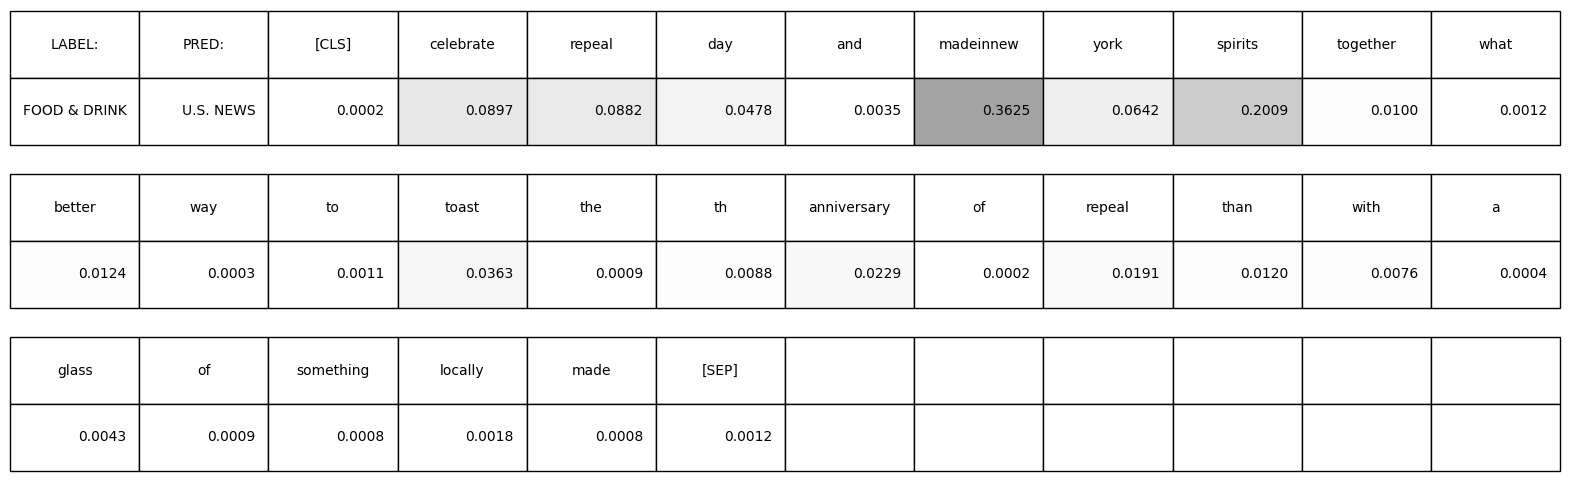

In [12]:
i = 1
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = NewsCategory.target2label(labels[i].item())
prediction = NewsCategory.target2label(predictions[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:", "PRED:"] + words
attn_strs = [label, prediction] + [f"{a:.4f}" for a in values]
colors = ["w", "w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()